## Methods for Nonlinear Electrochemical Impedance Spectroscopy to Probe the Nonlinear Dynamics of Lithium-ion Batteries
# Supplementary Notebook 

### Matthew D. Murbach$^=$, Victor W. Hu$^=$, and Daniel T. Schwartz<br>*Clean Energy Institute & Department of Chemical Engineering,<br>University of Washington*

### [GitHub Repo](https://github.com/mdmurbach/nleis-battery-manuscript)

## List of Figures

### - [Figure 1. Time and Frequency Domain Signals](#Figure-1.-Time-and-Frequency-Domain-Signals)
### - [Figure 2. Amplitude Dependence](#Figure-2.-Amplitude-Dependence)
### - [Figure 3. Full Frequency NLEIS spectrum](#Figure-3.-Full-Frequency-NLEIS-spectrum)
### - [Figure 4. Effect of State-of-Charge](#Figure-4.-Effect-of-State-of-Charge)
### - [Figure 5. Effect of State-of-Health](#Figure-5.-Effect-of-State-of-Health)
### - [Figure 6. Physics-based modeling](#Figure-6.-Physics-based-Modeling)
### - [Figure 7. Model interpretation of symmetry](#Figure-7.-Model-interpretation-of-symmetry)

## Miscellaneous

### - [Cell to Cell variation](#Cell-to-cell-variation)
### - [Kramer-Kronig validation](#Kramer-Kronig-Validation)
### - [Pure Resistor Data: Instrument Offset](#Pure Resistor Data: Instrument Offset)

### Figure 1. Time and Frequency Domain Signals

C:\Users\Victor\Anaconda3\envs\nleis-manuscript\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


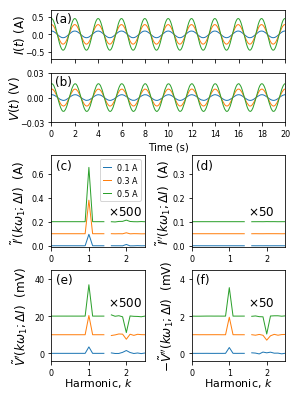

In [2]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from utilities.analysis import phase_correction

directory = '../data/raw/aged/cell_5/many-amplitudes/'

plot_SoC = 30
plot_frequency = 0.50119
plot_amplitudes = [0.1, 0.3, 0.5]

count = 0 
shift = 40
HARMONIC_MULTIPLIER_REAL = 500
HARMONIC_MULTIPLIER_IMAG = 50

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create figure and axes
fig1 = plt.figure(1, figsize=(3.25,4.875))
ax11 = fig1.add_axes([0.0, 0.860, 1.0, 0.14])  # [left, bottom, width, height]
ax12 = fig1.add_axes([0.0, 0.680, 1.0, 0.14])
ax21 = fig1.add_axes([0.0, 0.325, 0.4, 0.26]) 
ax22 = fig1.add_axes([0.0, 0.000, 0.4, 0.26])
ax31 = fig1.add_axes([0.6, 0.325, 0.4, 0.26])
ax32 = fig1.add_axes([0.6, 0.000, 0.4, 0.26])

filenames, order = [], []
for filename in os.listdir(directory):
    if filename.startswith(str(plot_SoC)):
        data = np.genfromtxt(directory + filename, delimiter=',', skip_header=1)
        frequency, amplitude = data[0,3], data[0,4]
        
        if frequency == plot_frequency and amplitude in plot_amplitudes:
            filenames.append(filename)
            order.append(plot_amplitudes.index(amplitude))
            
filenames_to_use = [f for _,f in sorted(zip(order,filenames))]

for filename in filenames_to_use:
    data = np.genfromtxt(directory + filename, delimiter=',', skip_header=1)
    frequency, amplitude = data[0,3], data[0,4]
    time, current, voltage = data[:,0], data[:,1], data[:,2]

    cyc = (time[-1] + time[1])*frequency
    index = int(round(cyc))
    N = len(voltage)

    i_hat = np.fft.fft(current)/(N/2) # Normalize FFT results
    v_hat = np.fft.fft(voltage)/(N/2) # using N/2 (results in mA/mV)

    M = (np.concatenate([np.arange(0,N/2),np.arange(-N/2,0)])/(cyc)).tolist()

    i_hat_shift, v_hat_shift = phase_correction(i_hat, v_hat, index)

    d = {}
    count1 = 0
    count2 = 0
    v = np.zeros(3, dtype = 'complex128')
    k_idx = np.array(M[0:6*index])
    v_idx = np.array(v_hat_shift[0:6*index])
    i_idx = np.array(i_hat_shift[0:6*index])
    k_ids = np.array([np.argwhere(np.isclose(k_idx, 1.0, rtol=5e-4)),
                      np.argwhere(np.isclose(k_idx, 2.0, rtol=5e-4)),
                      np.argwhere(np.isclose(k_idx, 3.0, rtol=5e-4))]).flatten()

    d['whole_k'] = np.array(M[0:6*index])
    d['uncorrected_i'] = np.array(i_hat_shift[0:6*index])
    d['uncorrected_v'] = np.array(v_hat_shift[0:6*index])

    for n in k_ids:
        d[count1 + 1] = {}
        k_baseline = np.concatenate((np.array(k_idx[n-5:n-1]), np.array(k_idx[n+2:n+6])), axis = 0)
        vr_baseline = np.concatenate((np.real(np.array(v_idx[n-5:n-1])), np.real(np.array(v_idx[n+2:n+6]))), axis = 0)
        vi_baseline = np.concatenate((np.imag(np.array(v_idx[n-5:n-1])), np.imag(np.array(v_idx[n+2:n+6]))), axis = 0)
        ir_baseline = np.concatenate((np.real(np.array(i_idx[n-5:n-1])), np.real(np.array(i_idx[n+2:n+6]))), axis = 0)
        ii_baseline = np.concatenate((np.imag(np.array(i_idx[n-5:n-1])), np.imag(np.array(i_idx[n+2:n+6]))), axis = 0)

        # Quadratic Fits
        baseline_vreal = np.polyfit(k_baseline, vr_baseline, 2)
        baseline_vimag = np.polyfit(k_baseline, vi_baseline, 2)

        baseline_ireal = np.polyfit(k_baseline, ir_baseline, 2)
        baseline_iimag = np.polyfit(k_baseline, ii_baseline, 2)

        ks_to_sub = np.linspace(np.min(k_baseline), np.max(k_baseline[:-1]), 10)
        real_fit = np.poly1d(baseline_vreal)
        imag_fit = np.poly1d(baseline_vimag)

        real_ifit = np.poly1d(baseline_ireal)
        imag_ifit = np.poly1d(baseline_iimag)

        bsr = real_fit(ks_to_sub)
        bsi = imag_fit(ks_to_sub)

        bsri = real_ifit(ks_to_sub)
        bsii = imag_ifit(ks_to_sub)

        cbs = np.zeros(len(bsr), dtype = 'complex128')
        cbsi = np.zeros(len(bsri), dtype = 'complex128')

        for i in range(len(bsr)):
            cbs[i] = np.complex(bsr[i], bsi[i])
            cbsi[i] = np.complex(bsri[i], bsii[i])

        d[count1 + 1]['n'] = n
        d[count1 + 1]['k'] = ks_to_sub
        d[count1 + 1]['calculated_vbs'] = cbs
        d[count1 + 1]['calculated_ibs'] = cbsi
        d[count1 + 1]['exp_v'] = v_idx[n-5:n+5]
        d[count1 + 1]['exp_i'] = i_idx[n-5:n+5]
        d[count1 + 1]['baseline_vsub'] = v_idx[n-5:n+5] - cbs
        d[count1 + 1]['baseline_isub'] = i_idx[n-5:n+5] - cbsi

        count1 += 1

    for n in k_ids:
        v_idx[n-5:n+5] = d[count2 + 1]['baseline_vsub']
        v_idx[n-5:n+5]

        i_idx[n-5:n+5] = d[count2 + 1]['baseline_isub']
        i_idx[n-5:n+5]
        count2 += 1
    
    i_corr = np.real(np.fft.ifft(i_hat_shift*(N/2)))
    v_corr = np.real(np.fft.ifft(v_hat_shift*(N/2)))

    color = color_list[count]

    # Subplot (a) (Current vs Time)
    ax11.plot(time, i_corr, linewidth=1, color = color)

    # Subplot (b) (Voltage vs Time)
    ax12.plot(time, v_corr, linewidth=1, color = color)

    # Subplot (c) (Real FFT current)
    ax21.plot(M[:int(index*1.5)], np.real(i_idx[:int(index*1.5)]) + .1*count,'-', linewidth=1, color = color, label = '{} A'.format(amplitude))
    ax21.plot(M[int(index*1.5)+1:6*index], HARMONIC_MULTIPLIER_REAL*np.real(i_idx[int(index*1.5)+1:6*index]) + .1*count,'-', linewidth=1, color = color)

    # Subplot (d) (Imag FFT current)
    ax31.plot(M[:int(index*1.5)], -np.imag(i_idx[:int(index*1.5)]) + .05*count,'-', linewidth=1, color = color)
    ax31.plot(M[int(index*1.5)+1:6*index], -HARMONIC_MULTIPLIER_IMAG*np.imag(i_idx[int(index*1.5)+1:6*index]) + .05*count,'-', linewidth=1, color = color)

    # Subplot (e) (Real FFT voltage)
    ax22.plot(M[:int(index*1.5)], 1000*np.real(v_hat_shift[:int(index*1.5)]) + 10*count,'-', linewidth=1, color = color)
    ax22.plot(M[int(index*1.5)+1:6*index], 1000*HARMONIC_MULTIPLIER_REAL*np.real(v_idx[int(index*1.5)+1:6*index]) + 10*count,'-', linewidth=1, color = color)

    # Subplot (f) (Imag FFT voltage)
    ax32.plot(M[:int(index*1.5)], -1000*np.imag(v_hat_shift[:int(index*1.5)]) + 1*count,'-', linewidth=1, color = color)
    ax32.plot(M[int(index*1.5)+1:6*index], -1000*HARMONIC_MULTIPLIER_IMAG*np.imag(v_idx[int(index*1.5)+1:6*index]) + 1*count,'-', linewidth=1, color = color)

    count+=1
            
# Subplot (a) (Current vs Time)          
ax11.set_xlim(0, 10/plot_frequency)
ax11.set_ylim(-.7, .7)
y_ticks = np.linspace(-.500, .500, num=3, endpoint=True)
ax11.set_yticks(y_ticks)
ax11.set_ylabel(r'$I (t)\ \mathrm{(A)}$', fontsize=12, labelpad=-2)
ax11.set_xticklabels([])

# Subplot (b) (Voltage vs Time)
ax12.set_xlim(0, 10/plot_frequency)
ax12.set_ylim(-.03,.03)
y_ticks = np.linspace(-.03, .03, num=3, endpoint=True)
ax12.set_yticks(y_ticks)
ax12.set_xlabel('Time (s)', fontsize=10, labelpad=3)
ax12.set_ylabel(r'$V (t)\ \mathrm{(V)}$', fontsize=12, labelpad=-2)

# Subplot (c) (Real FFT current)
ax21.set_ylim(-.008,.75)
y_ticks = np.linspace(0, .600, num=4, endpoint=True)
ax21.set_yticks(y_ticks)
ax21.set_ylabel(r'$\tilde I^{\prime} \left(k\omega_1; \Delta I\right) \ \ \mathrm{(A)}$', fontsize=12)
# ax21.text(1.25,.018, r'$\Delta I$ = 100 mA', fontsize=8)
# ax21.text(1.25,.118, r'$\Delta I$ = 300 mA', fontsize=8)
# ax21.text(1.25,.218, r'$\Delta I$ = 500 mA', fontsize=8)
ax21.text(.6, .35, r'$\times ' + str(HARMONIC_MULTIPLIER_REAL) + '$', fontsize= 12, transform=ax21.transAxes)
ax21.legend(loc='upper right', fontsize=8, handlelength=1)

# Subplot (d) (Imag FFT current)
ax31.set_ylim(-.004,.375)
y_ticks = np.linspace(0, .300, num=4, endpoint=True)
ax31.set_yticks(y_ticks)
ax31.text(.6, .35, r'$\times ' + str(HARMONIC_MULTIPLIER_IMAG) + '$', fontsize= 12, transform=ax31.transAxes)
ax31.set_ylabel(r'$\tilde I^{\prime\prime} \left(k\omega_1; \Delta I\right) \ \ \mathrm{(A)}$',
           fontsize=12, labelpad=-.5)

# Subplot (e) (Real FFT voltage)
ax22.set_ylim(-4, 45)
y_ticks = np.linspace(0, 40, num=3, endpoint=True)
ax22.set_yticks(y_ticks)
ax22.set_ylabel(r'$\tilde V^{\prime} \left(k\omega_1; \Delta I\right) \ \ \mathrm{(mV)}$', fontsize=12)
ax22.text(.6, .6, r'$\times ' + str(HARMONIC_MULTIPLIER_REAL) + '$', fontsize= 12, transform=ax22.transAxes)
ax22.set_xlabel('Harmonic, $k$', fontsize=11, labelpad=-1)

# Subplot (f) (Imag FFT voltage)
ax32.set_ylim(-.4,4.5)
y_ticks = np.linspace(0, 4, num=3, endpoint=True)
ax32.set_yticks(y_ticks)
ax32.set_xlabel('Harmonic, $k$', fontsize=11, labelpad=-1)
ax32.set_ylabel(r'$- \tilde V^{\prime\prime} \left(k\omega_1; \Delta I\right) \ \ \mathrm{(mV)}$', 
           fontsize=12, labelpad=4)
ax32.text(.6, .6, r'$\times ' + str(HARMONIC_MULTIPLIER_IMAG) + '$', fontsize= 12, transform=ax32.transAxes)

for ax in [ax11, ax12, ax21, ax31, ax22, ax32]:
    ax.tick_params(right="off")
    ax.tick_params(top="off")
    ax.tick_params(axis='both', which='major', labelsize=8)

labels = 'ab'
for i, ax in enumerate([ax11, ax12]):
    ax.text(.015, .75, '(' + labels[i] + ')', fontsize= 12, transform=ax.transAxes)
    
labels = 'cdef'
for i, ax in enumerate([ax21, ax31, ax22, ax32]):
    ax.text(.045, .85, '(' + labels[i] + ')', fontsize= 12, transform=ax.transAxes)

for ax in [ax11, ax12]:
    ax.set_xlim(0,20)
    x_ticks = np.linspace(0, 20,num=11,endpoint=True)
    ax.set_xticks(x_ticks)    
    
for ax in [ax21, ax22, ax31, ax32]:
    ax.set_xlim(0,2.5)
    x_ticks = np.linspace(0, 2,num=3,endpoint=True)
    ax.set_xticks(x_ticks)

plt.show()

fig1.savefig('../figures/Figure1.pdf', format='pdf', dpi=300, bbox_inches='tight')

### Figure 2. Amplitude Dependence

In [3]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
from utilities.plotting import FixedOrderFormatter
from utilities.analysis import fft_baseline_subt, phase_correction

def fit_V1(i11, v11):
    return v11*i11

def fit_V2(i11, v22):
    return v22*i11**2

def fit_V3(i11, v33):
    return v33*i11**3

directory = '../data/raw/aged/cell_5/many-amplitudes/'
plot_frequency = 0.50119
plot_amplitudes = []
fig_dict = {}
j = 0

for filename in sorted(os.listdir(directory)):
    if filename.split('-')[0].startswith('30'):
        data = np.genfromtxt(directory + filename, delimiter=',', skip_header=1)
        frequency, amplitude = data[0,3], data[0,4]
        time, current, voltage = data[:,0], data[:,1], data[:,2]
        if amplitude not in fig_dict:
            fig_dict[amplitude] = {}
            plot_amplitudes.append(amplitude)
        if frequency not in fig_dict.get(amplitude):
            fig_dict[amplitude][frequency] = {}
        if frequency == plot_frequency and amplitude in plot_amplitudes:
            
            cyc = (time[-1] + time[1])*frequency
            index = int(round(cyc))

            N = len(voltage)

            i_hat = np.fft.fft(current)/(N/2) # Normalize FFT results
            v_hat = np.fft.fft(voltage)/(N/2) # using N/2 (results in A/V)

            M = (np.concatenate([np.arange(0,N/2),np.arange(-N/2,0)])/(cyc)).tolist()

            i_hat_shift, v_hat_shift = phase_correction(i_hat, v_hat, index)
            
            v_baselined = fft_baseline_subt(M, v_hat_shift, index)
            i_baselined = fft_baseline_subt(M, i_hat_shift, index)

            fig_dict[amplitude][frequency]['i_1'] = i_baselined[0]
            fig_dict[amplitude][frequency]['i_2'] = i_baselined[1]
            fig_dict[amplitude][frequency]['i_3'] = i_baselined[2]

            fig_dict[amplitude][frequency]['v_1'] = v_baselined[0]
            fig_dict[amplitude][frequency]['v_2'] = v_baselined[1]
            fig_dict[amplitude][frequency]['v_3'] = v_baselined[2]

for frequency in sorted(fig_dict[plot_amplitudes[0]]):
    if frequency == plot_frequency:
        n_amp = len(fig_dict)
        i_1 = np.zeros(n_amp)
        v_1 = np.zeros(n_amp, dtype = np.complex128)
        v_2 = np.zeros(n_amp, dtype = np.complex128)
        v_3 = np.zeros(n_amp, dtype = np.complex128)
        for i in range(len(fig_dict)):
            amplitude = sorted(fig_dict.keys())[i]
            if amplitude in fig_dict.keys():
                i_1[i] = np.real(fig_dict[amplitude][frequency]['i_1'])
                v_1[i] = fig_dict[amplitude][frequency]['v_1']
                v_2[i] = fig_dict[amplitude][frequency]['v_2']
                v_3[i] = fig_dict[amplitude][frequency]['v_3']

i_1_3ptfit = np.array([i_1[10], i_1[14], i_1[18]])
v_1_3ptfit = np.array([v_1[10], v_1[14], v_1[18]])
v_2_3ptfit = np.array([v_2[10], v_2[14], v_2[18]])
v_3_3ptfit = np.array([v_3[10], v_3[14], v_3[18]])

fit_11_3pt_real, tmp1 = curve_fit(fit_V1, i_1_3ptfit, np.real(v_1_3ptfit))
fit_11_3pt_rstd = np.sqrt(tmp1)

fit_11_3pt_imag, tmp2 = curve_fit(fit_V1, i_1_3ptfit, np.imag(v_1_3ptfit))
fit_11_3pt_istd = np.sqrt(tmp2)

fit_11_33mA_real, tmp5 = curve_fit(fit_V1, i_1[1], np.real(v_1)[1])
fit_11_33mA_imag, tmp6 = curve_fit(fit_V1, i_1[1], np.imag(v_1)[1])

CI_real = fit_11_3pt_rstd[0][0]*2
CI_imag = fit_11_3pt_istd[0][0]*2

fit_22_3pt_real, tmp3 = curve_fit(fit_V2, i_1_3ptfit, np.real(v_2_3ptfit))
fit_22_3pt_rstd = np.sqrt(tmp3)

fit_22_3pt_imag, tmp4 = curve_fit(fit_V2, i_1_3ptfit, np.imag(v_2_3ptfit))
fit_22_3pt_istd = np.sqrt(tmp4)

print("3 point fits:\n\tZ1'  = {:.2e} (std. = {:.2e}) Ohms\n\tZ1'' = {:.2e} (std. = {:.2e}) Ohms\n".format(fit_11_3pt_real[0], fit_11_3pt_rstd[0][0], fit_11_3pt_imag[0], fit_11_3pt_istd[0][0]))

print("Percent error of real and imag component is {:.2f}% and {:.2f}%\n".format(200*fit_11_3pt_rstd[0][0]/fit_11_3pt_real[0], abs(200*fit_11_3pt_istd[0][0]/fit_11_3pt_imag[0])))

print("For Z1 real, the 95% confidence intervals lie between", str(fit_11_3pt_real[0] - CI_real), "and", str(fit_11_3pt_real[0] + CI_real), 'Ohms')
print("For Z1 imag, the 95% confidence intervals lie between", str(fit_11_3pt_imag[0] + CI_imag), "and", str(fit_11_3pt_imag[0] - CI_imag), 'Ohms')
print('\n')
print('The calculated Z1 real and imag from the 33mA perturbation is',str(fit_11_33mA_real[0]),str(fit_11_33mA_imag[0]),"Ohms, respectively")

3 point fits:
	Z1'  = 3.73e-02 (std. = 8.40e-05) Ohms
	Z1'' = -3.39e-03 (std. = 8.57e-06) Ohms

Percent error of real and imag component is 0.45% and 0.51%

For Z1 real, the 95% confidence intervals lie between 0.037142334042274495 and 0.03747816208661819 Ohms
For Z1 imag, the 95% confidence intervals lie between -0.0033739520792663525 and -0.0034082226235188917 Ohms


The calculated Z1 real and imag from the 33mA perturbation is 0.03738106506983523 -0.003363735005442633 Ohms, respectively


C:\Users\Victor\Anaconda3\envs\nleis-manuscript\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


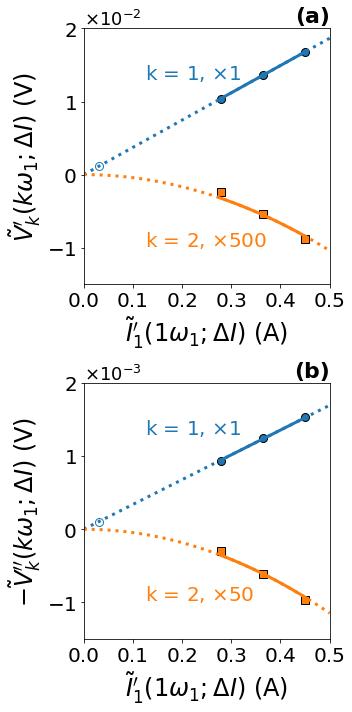

In [4]:
x_dashed = np.linspace(0.00, 0.50, num = 50)
x_solid = np.linspace(i_1[10], i_1[18], num = 50)

fig1 = plt.figure(1, figsize=(5,10))
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)

h_scale_real = float(500.0)
h_scale_imag = float(50.0)

ax1.plot(i_1_3ptfit, np.real(v_1_3ptfit), 'o', color='#1f77b4', markersize=8, mec='black')
ax1.plot(x_solid, fit_11_3pt_real[0]*x_solid,  '-', linewidth=3, color='#1f77b4')
ax1.plot(x_dashed, fit_11_3pt_real[0]*x_dashed, ':', linewidth=3, color='#1f77b4')
ax1.plot(i_1[1], np.real(v_1[1]), 'o', color='#1f77b4', markersize=8, mec='#1f77b4', markerfacecolor='none')

ax1.plot(i_1_3ptfit, h_scale_real*np.real(v_2_3ptfit), 's', color='#ff7f0e', markersize=8, mec='black')
ax1.plot(x_solid, h_scale_real*fit_22_3pt_real[0]*x_solid**2, '-', linewidth=3, color='#ff7f0e')
ax1.plot(x_dashed, h_scale_real*fit_22_3pt_real[0]*x_dashed**2, ':', linewidth=3, color='#ff7f0e')
# ax1.plot(i_1[1], h_scale_real*np.real(v_2[1]),'s', color='#ff7f0e', markersize=8, mec='#ff7f0e', markerfacecolor='none')

ax1.set_xlabel(r'$\tilde{I}^{\prime}_1 (1\omega_{1};\Delta I)$ (A)', fontsize=24)
ax1.set_ylabel(r'$\tilde{V}^{\prime}_k (k\omega_{1};\Delta I)$ (V)', fontsize=24)
ax1.set_ylim(-0.015, 0.020)
ax1.yaxis.set_major_formatter(FixedOrderFormatter(-2))
ax1.set_title('(a)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')

ax2.plot(i_1_3ptfit, -np.imag(v_1_3ptfit), 'o', color='#1f77b4', markersize=8, mec='black')
ax2.plot(x_solid, -fit_11_3pt_imag[0]*x_solid, linewidth=3, color='#1f77b4')
ax2.plot(x_dashed, -fit_11_3pt_imag[0]*x_dashed, ':', linewidth=3, color='#1f77b4')
ax2.plot(i_1[1], -np.imag(v_1[1]), 'o', color='#1f77b4', markersize=8, mec='#1f77b4', markerfacecolor='none')

ax2.plot(i_1_3ptfit, -h_scale_imag*np.imag(v_2_3ptfit), 's', color='#ff7f0e', markersize=8, mec='black')
ax2.plot(x_solid, -h_scale_imag*fit_22_3pt_imag[0]*x_solid**2, '-', linewidth=3, color='#ff7f0e')
ax2.plot(x_dashed, -h_scale_imag*fit_22_3pt_imag[0]*x_dashed**2, ':', linewidth=3, color='#ff7f0e')
# ax2.plot(i_1[1], -h_scale_imag*np.imag(v_2[1]),'s', color='#ff7f0e', markersize=8, mec='#ff7f0e', markerfacecolor='none')

ax2.set_xlabel(r'$\tilde{I}^{\prime}_1 (1\omega_{1};\Delta I)$ (A)', fontsize=24)
ax2.set_ylabel(r'$\tilde{-V}^{\prime\prime}_k (k\omega_{1};\Delta I)$ (V)', fontsize=24)
ax2.set_ylim(-0.0015, 0.0020)
ax2.yaxis.set_major_formatter(FixedOrderFormatter(-3))
ax2.set_title('(b)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')

for i, ax in enumerate([ax1, ax2]):
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlim(0,.5)
    ax.set_xticks(np.arange(0,.6,.1))
    
    y_offset = ax.yaxis.get_offset_text()
    y_offset.set_size(18)

ax1.text(0.25, 0.8, 'k = 1, ' + r'$\times 1$', fontsize=20, transform=ax1.transAxes, color='#1f77b4')
ax1.text(0.25, 0.15, 'k = 2, ' + r'$\times 500$', fontsize=20, transform=ax1.transAxes, color='#ff7f0e')
ax2.text(0.25, 0.8, 'k = 1, ' + r'$\times 1$', fontsize=20, transform=ax2.transAxes, color='#1f77b4')
ax2.text(0.25, 0.15, 'k = 2, ' + r'$\times 50$', fontsize=20, transform=ax2.transAxes, color='#ff7f0e')

plt.tight_layout()

plt.show()

fig1.savefig('../figures/Figure2.pdf', dpi=300, bbox_inches='tight')

### Figure 3. Typical Full Frequency NLEIS spectrum

In [4]:
import numpy as np
from utilities.analysis import get_impedances

directories = ['../data/raw/new/cell_1/']
SoCs = ['50']

frequencies, Z1s, Z2s = get_impedances(directories=directories, SoCs=SoCs, 
                                       correction=np.complex(4.55540783501e-5, -1.74911871095e-06))

np.savetxt('../data/Figure3/freq.txt',frequencies)
np.savetxt('../data/Figure3/Z1s.txt', np.array(Z1s).view(float))
np.savetxt('../data/Figure3/Z2s.txt', np.array(Z2s).view(float))

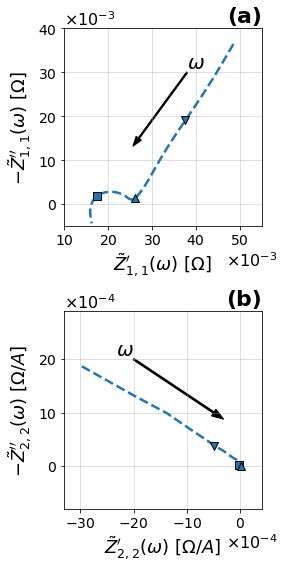

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from utilities.plotting import plot_nyquist

frequencies = np.loadtxt('../data/Figure3/freq.txt')
Z1s = np.loadtxt('../data/Figure3/Z1s.txt').view(complex)
Z2s = np.loadtxt('../data/Figure3/Z2s.txt').view(complex)

names = ['50%']

mask = np.array(frequencies) <= 1000

fig1 = plt.figure(1, figsize=(4,8))
ax1 = fig1.add_subplot(211)
ax1 = plot_nyquist(fig1, ax1, frequencies, np.array([Z1s]), 1, '', [[.01,.055],[-.005,.04], -3], names=names, markers=[1e3, 1, .01])
ax1.set_title('(a)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')
ax1.text(38e-3, 30e-3, '$\omega$', ha='left', va='bottom', fontsize=20)
ax1.arrow(38e-3, 30e-3, -11e-3, -15e-3, width=3e-4, head_width = 1.5e-3, fc='k', ec='k')

ax2 = fig1.add_subplot(212)
ax2 = plot_nyquist(fig1, ax2, frequencies, np.array([Z2s]), 2, '', [[-33e-4, 4e-4],[-8e-4, 29e-4], -4], mask=mask, markers=[1e3, 1, .01])
ax2.set_title('(b)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')
ax2.text(-20e-4, 20e-4, '$\omega$', ha='right', va='bottom', fontsize=20)
ax2.arrow(-20e-4, 20e-4, 15e-4, -10e-4, width=3e-5, head_width = 1.5e-4, fc='k', ec='k')

ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

fig1.savefig('../figures/Figure3.pdf', dpi=300, bbox_inches='tight')

### Figure 4. Effect of State-of-Charge

In [7]:
import numpy as np
from utilities.analysis import get_impedances

directories = ['../data/raw/new/cell_1/']
SoCs = ['10', '30', '50']

frequencies, Z1s, Z2s = get_impedances(directories=directories, SoCs=SoCs, 
                                       correction=np.complex(4.55540783501e-5, -1.74911871095e-06))

np.savetxt('../data/Figure4/freq.txt',frequencies)
np.savetxt('../data/Figure4/Z1s.txt', np.array(Z1s).view(float))
np.savetxt('../data/Figure4/Z2s.txt', np.array(Z2s).view(float))

C:\Users\Victor\Anaconda3\envs\nleis-manuscript\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Victor\Anaconda3\envs\nleis-manuscript\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


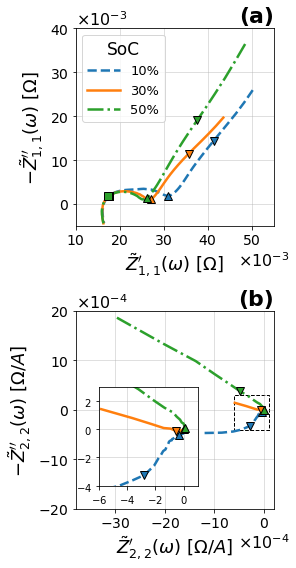

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid.inset_locator import inset_axes

from utilities.plotting import plot_nyquist

frequencies = np.loadtxt('../data/Figure4/freq.txt')
Z1s = np.loadtxt('../data/Figure4/Z1s.txt').view(complex)
Z2s = np.loadtxt('../data/Figure4/Z2s.txt').view(complex)

names = ['10%', '30%', '50%']

mask = np.array(frequencies) < 10

fig1 = plt.figure(1, figsize=(4,8))
ax1 = fig1.add_subplot(211)
ax1 = plot_nyquist(fig1, ax1, frequencies, Z1s, 1, '', [[.01,.055],[-.005,.04], -3], names=names, markers=[1000, 1, .01])
ax1.set_title('(a)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')

ax2 = fig1.add_subplot(212)
ax2 = plot_nyquist(fig1, ax2, frequencies, Z2s, 2, '', [[-38e-4, 2e-4],[-20e-4, 20e-4], -4], mask=mask, markers=[None, 1, .01])
ax2.set_title('(b)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')

ax3 = inset_axes(ax2, loc=3, borderpad=2.3, width="50%",  height="50%")
ax3 = plot_nyquist(fig1, ax3, frequencies, Z2s, 2, '', [[-6e-4, 1e-4],[-4e-4, 3e-4], -4], mask=mask, markers=[None, 1, .01])
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.grid(b=True, which='major', axis='both', alpha=.5)
y_offset = ax3.yaxis.get_offset_text()
y_offset.set_visible(False)

t = ax3.xaxis.get_offset_text()
t.set_visible(False)

ax1.legend(title='SoC', handlelength=2.5, fontsize=13)
ax1.get_legend().get_title().set_size('17')

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')

for ax in [ax2]:
    ax.add_patch(
    patches.Rectangle(
        (-6e-4, -4e-4),
        7e-4,
        7e-4,
        fill=False,
        ls='--'
        )
    )
plt.tight_layout()
plt.show()

fig1.savefig('../figures/Figure4.pdf', dpi=300, bbox_inches='tight')

### Figure 5. Effect of State-of-Health

In [9]:
import numpy as np
from utilities.analysis import get_impedances

directories = ['../data/raw/new/cell_1/',
               '../data/raw/aged/cell_4/']

frequencies, Z1s, Z2s = get_impedances(directories=directories, SoCs=['30'], 
                                                 correction=np.complex(4.55540783501e-5, -1.74911871095e-06))

np.savetxt('../data/Figure5/freq.txt',frequencies)
np.savetxt('../data/Figure5/Z1s.txt', np.array(Z1s).view(float))
np.savetxt('../data/Figure5/Z2s.txt', np.array(Z2s).view(float))

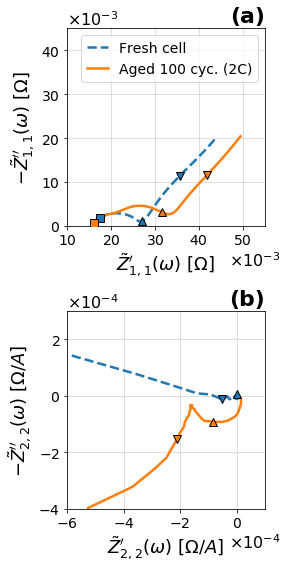

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from utilities.plotting import plot_nyquist

frequencies = np.loadtxt('../data/Figure5/freq.txt')
Z1s = np.loadtxt('../data/Figure5/Z1s.txt').view(complex)
Z2s = np.loadtxt('../data/Figure5/Z2s.txt').view(complex)

names = ['Fresh cell', 'Aged 100 cyc. (2C)']

mask = np.array(frequencies) < 10
        
fig1 = plt.figure(1, figsize=(4,8))
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)
ax1 = plot_nyquist(fig1, ax1, frequencies, Z1s, 1, '', [[.01,.055],[0,.045], -3], names=names, markers=[1000, 1, .01])
ax1.set_title('(a)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')
ax2 = plot_nyquist(fig1, ax2, frequencies, Z2s, 2, '', [[-6e-4, 1e-4],[-4e-4, 3e-4], -4], mask=mask, markers=[None, 1, .01])
ax2.set_title('(b)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax1.legend(handlelength=1.5, fontsize=14)

plt.tight_layout()
plt.show()

fig1.savefig('../figures/Figure5.pdf', dpi=300, bbox_inches='tight')

### Figure 6. Physics-based Modeling

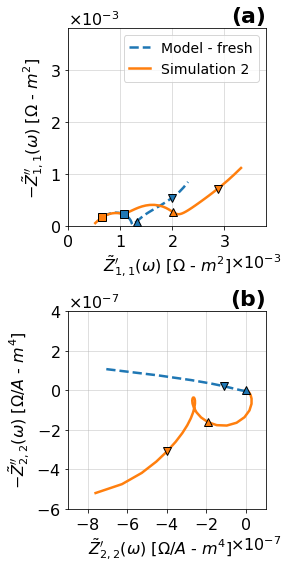

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from utilities.plotting import plot_nyquist_sim

Z1s_model, Z2s_model = [], []

newcell = '../data/simulations/spectra-new_cell.txt'
agedcell = '../data/simulations/spectra-aged_cell.txt'

filenames = [newcell, agedcell]

for filename in filenames:
    data = np.loadtxt(filename)
    frequencies_model = data[0]
    Z1s_model.append(data[1] - 1j*data[2])
    Z2s_model.append(data[3] - 1j*data[4])

mask_model = np.array(frequencies_model) < 11

fig1 = plt.figure(1, figsize=(4,8))
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)
ax1 = plot_nyquist_sim(fig1, ax1, frequencies_model, Z1s_model, 1, '', [[-.000,.0038],[0,.0038], -3], markers=[1000, 1, .01], names=['Model - fresh', 'Simulation 2'])
ax1.set_title('(a)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')
ax2 = plot_nyquist_sim(fig1, ax2, frequencies_model, Z2s_model, 2, '', [[-.9e-6,.1e-6],[-.6e-6,.4e-6], -7], markers=[None, 1, .01])
ax2.set_title('(b)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax1.legend(handlelength=1.5, fontsize=14)

plt.tight_layout()
plt.show()

fig1.savefig('../figures/Figure6.pdf', dpi=300, bbox_inches='tight')

### Figure 7. Model interpretation of symmetry

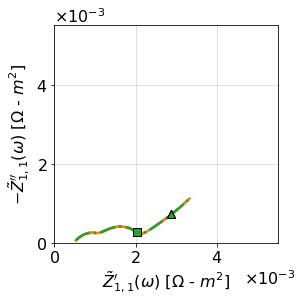

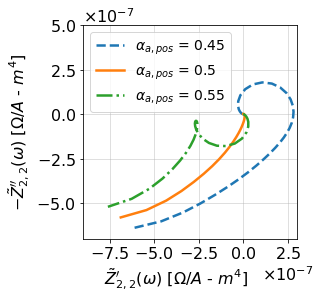

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utilities.plotting import plot_nyquist_sim

Z1s, Z2s = [], []
names = []
directory = '../data/simulations/sweep_agedaa_pos/'
for filename in sorted(os.listdir(directory)):
    aa = float(filename.split('aa_pos-')[-1].split('.txt')[0])
    if filename.startswith('spectra') and aa in [0.45, 0.5, 0.55]:
        
        data = np.loadtxt(directory + filename)

        frequencies = data[0]
        Z1s.append(data[1] - 1j*data[2])
        Z2s.append(data[3] - 1j*data[4])
        names.append(r'$\alpha_{{a,pos}}$ = {}'.format(aa))
        
fig1 = plt.figure(figsize=(4,4))
ax1 = fig1.add_subplot(111)
ax1 = plot_nyquist_sim(fig1, ax1, frequencies, Z1s, 1, '', [[0,.0055],[0,.0055], -3], markers=[1, .01])

fig2 = plt.figure(figsize=(4.5,4.5))
ax2 = fig2.add_subplot(111)
ax2 = plot_nyquist_sim(fig2, ax2, frequencies, Z2s, 2, '', [[-.9e-6,.3e-6],[-.7e-6,.5e-6], -7], names=names)
ax2.legend(loc=2, fontsize=14)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

fig2.savefig('../figures/Figure7.pdf', dpi=300, bbox_inches='tight')

## Miscellaneous

### Cell to cell variation

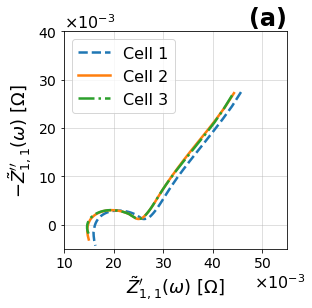

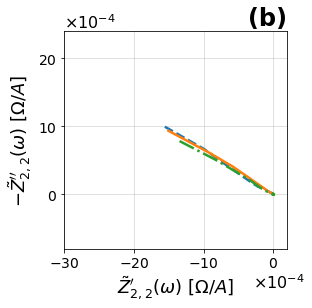

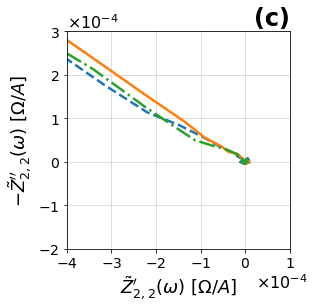

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utilities.plotting import plot_nyquist
from utilities.analysis import get_impedances

directories = ['../data/raw/new/' + cell for cell in ['cell_1/', 'cell_2/', 'cell_3/']]
names = ['Cell 1', 'Cell 2', 'Cell 3']
frequencies, Z1s, Z2s = get_impedances(directories=directories, SoCs=['40'], 
                                                 correction=np.complex(4.55540783501e-5, -1.74911871095e-06))
        
fig1 = plt.figure(1, figsize=(4,4))
ax1 = fig1.add_subplot(111)
ax1 = plot_nyquist(fig1, ax1, frequencies, Z1s, 1, '', [[.01,.055],[-.005,.04], -3], names=names)
ax1.set_title('(a)', weight='bold', family='sans-serif', fontsize=24, loc='right', verticalalignment='baseline')

fig2 = plt.figure(2, figsize=(4,4))
ax2 = fig2.add_subplot(111)
ax2 = plot_nyquist(fig2, ax2, frequencies, Z2s, 2, '', [[-30e-4, 2e-4],[-8e-4, 24e-4], -4], mask=mask)
ax2.set_title('(b)', weight='bold', family='sans-serif', fontsize=24, loc='right', verticalalignment='baseline')

fig3 = plt.figure(3, figsize=(4,4))
ax3 = fig3.add_subplot(111)
ax3 = plot_nyquist(fig3, ax3, frequencies, Z2s, 2, '', [[-4e-4, 1e-4],[-2e-4, 3e-4], -4], mask=mask)
ax3.set_title('(c)', weight='bold', family='sans-serif', fontsize=24, loc='right', verticalalignment='baseline')

plt.show()

### Kramer-Kronig Validation

In [15]:
KK_data = np.loadtxt('../data/raw/new/cell_1/kramers-kronig/new_cell_1_10%.txt', skiprows=1)
res_real = KK_data[:,0]
res_imag = KK_data[:,1]
freq = KK_data[:,4]

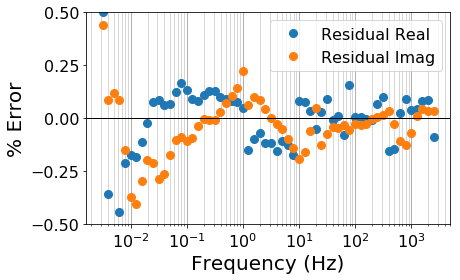

In [16]:
fig = plt.figure(1, figsize=(6.5,4))
plt.plot(freq, res_real, 'o', color='#1f77b4', markersize=8, label = "Residual Real")
plt.plot(freq, res_imag, 'o', color='#ff7f0e', markersize=8, label = "Residual Imag")

plt.tick_params(axis='both', labelsize = 16)
plt.axhline(y=0, color = 'black', lw = 1)
plt.xscale('log')
plt.grid(which='major', axis='x', lw = 1)
plt.grid(which='minor', axis='x', lw = 0.5)
plt.xlabel('Frequency (Hz)', fontsize = 20)
plt.ylabel('% Error', fontsize = 20)
plt.ylim([-0.5, 0.5])
plt.yticks(np.arange(-0.5, 0.6, 0.25))
plt.legend(fontsize = 16)

plt.tight_layout()
plt.show()

### Visualizing baseline corrections

65, 131, 197 = 3 mHz

60, 126, 192 = 10 mHz

In [17]:
import numpy as np
from utilities.analysis import phase_correction

data = np.genfromtxt('../data/raw/new/cell_1/10SOC_1500mAh_NMC_time-data_newcell1(197).txt', delimiter=',', skip_header=1)


frequency, amplitude = data[0,3], data[0,4]
time, current, voltage = data[:,0], data[:,1], data[:,2]

cyc = (time[-1] + time[1])*frequency
index = int(round(cyc))
N = len(voltage)
M = (np.concatenate([np.arange(0,N/2),np.arange(-N/2,0)])/(cyc)).tolist()

i_hat = np.fft.fft(current)/(N/2) # Normalize FFT results
v_hat = np.fft.fft(voltage)/(N/2) # using N/2 (results in mA/mV)

i_hat_shift, v_hat_shift = phase_correction(i_hat, v_hat, index)

d = {}
count = 0
count2 = 0
v = np.zeros(3, dtype = 'complex128')
k_idx = np.array(M[0:4*index])
v_idx = np.array(v_hat_shift[0:4*index])
i_idx = np.array(i_hat_shift[0:4*index])
k_ids = np.array([np.argwhere(np.isclose(k_idx, 1.0, rtol=5e-4)),
                  np.argwhere(np.isclose(k_idx, 2.0, rtol=5e-4)),
                  np.argwhere(np.isclose(k_idx, 3.0, rtol=5e-4))]).flatten()
 
d['whole_k'] = np.array(M[0:4*index])
d['uncorrected_i'] = np.array(i_hat_shift[0:4*index])
d['uncorrected_v'] = np.array(v_hat_shift[0:4*index])

for n in k_ids:
    d[count + 1] = {}
    k_baseline = np.concatenate((np.array(k_idx[n-5:n-1]), np.array(k_idx[n+2:n+6])), axis = 0)
    vr_baseline = np.concatenate((np.real(np.array(v_idx[n-5:n-1])), np.real(np.array(v_idx[n+2:n+6]))), axis = 0)
    vi_baseline = np.concatenate((np.imag(np.array(v_idx[n-5:n-1])), np.imag(np.array(v_idx[n+2:n+6]))), axis = 0)
    ir_baseline = np.concatenate((np.real(np.array(i_idx[n-5:n-1])), np.real(np.array(i_idx[n+2:n+6]))), axis = 0)
    ii_baseline = np.concatenate((np.imag(np.array(i_idx[n-5:n-1])), np.imag(np.array(i_idx[n+2:n+6]))), axis = 0)

    # Quadratic Fits
    baseline_vreal = np.polyfit(k_baseline, vr_baseline, 2)
    baseline_vimag = np.polyfit(k_baseline, vi_baseline, 2)
    
    baseline_ireal = np.polyfit(k_baseline, ir_baseline, 2)
    baseline_iimag = np.polyfit(k_baseline, ii_baseline, 2)

    ks_to_sub = np.linspace(np.min(k_baseline), np.max(k_baseline[:-1]), 10)
    real_fit = np.poly1d(baseline_vreal)
    imag_fit = np.poly1d(baseline_vimag)
    
    real_ifit = np.poly1d(baseline_ireal)
    imag_ifit = np.poly1d(baseline_iimag)
    
    bsr = real_fit(ks_to_sub)
    bsi = imag_fit(ks_to_sub)
    
    bsri = real_ifit(ks_to_sub)
    bsii = imag_ifit(ks_to_sub)
    
    cbs = np.zeros(len(bsr), dtype = 'complex128')
    cbsi = np.zeros(len(bsri), dtype = 'complex128')

    for i in range(len(bsr)):
        cbs[i] = np.complex(bsr[i], bsi[i])
        cbsi[i] = np.complex(bsri[i], bsii[i])

    d[count + 1]['n'] = n
    d[count + 1]['k'] = ks_to_sub
    d[count + 1]['calculated_vbs'] = cbs
    d[count + 1]['calculated_ibs'] = cbsi
    d[count + 1]['exp_v'] = v_idx[n-5:n+5]
    d[count + 1]['exp_i'] = i_idx[n-5:n+5]
    d[count + 1]['baseline_vsub'] = v_idx[n-5:n+5] - cbs
    d[count + 1]['baseline_isub'] = i_idx[n-5:n+5] - cbsi
    
    count += 1

for n in k_ids:
    v_idx[n-5:n+5] = d[count2 + 1]['baseline_vsub']
    v_idx[n-5:n+5]
    
    i_idx[n-5:n+5] = d[count2 + 1]['baseline_isub']
    i_idx[n-5:n+5]
    count2 += 1

Frequency = 0.0031623000000000003 Hz
Amplitude = 0.5 A


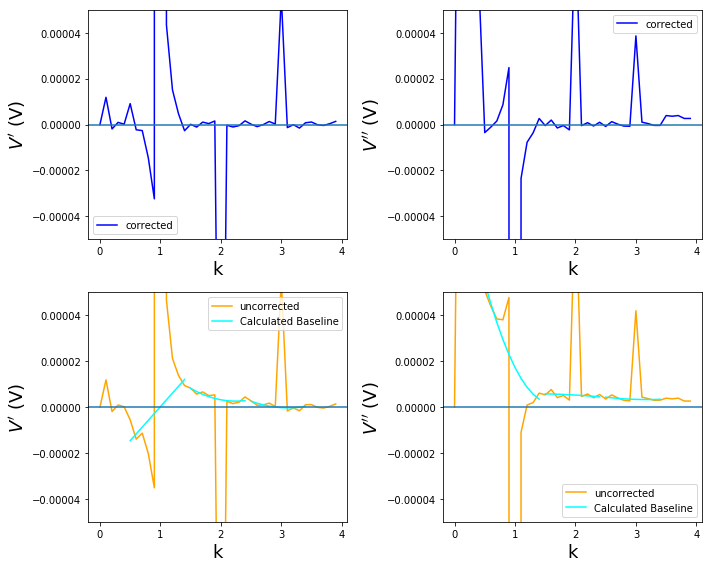

In [18]:
fig, ax = plt.subplots(2, 2, figsize = (10,8))

ax[0,0].plot(k_idx, np.real(v_idx), label = 'corrected', color = 'b')
ax[0,1].plot(k_idx, np.imag(v_idx), label = 'corrected', color = 'b')

ax[1,0].plot(k_idx, np.real(d['uncorrected_v']), label = 'uncorrected', color = 'orange')
ax[1,0].plot(d[1]['k'], np.real(d[1]['calculated_vbs']), color = 'cyan', label = 'Calculated Baseline')
ax[1,0].plot(d[2]['k'], np.real(d[2]['calculated_vbs']), color = 'cyan')
ax[1,0].plot(d[3]['k'], np.real(d[3]['calculated_vbs']), color = 'cyan')

ax[1,1].plot(k_idx, np.imag(d['uncorrected_v']), label = 'uncorrected', color = 'orange')
ax[1,1].plot(d[1]['k'], np.imag(d[1]['calculated_vbs']), color = 'cyan', label = 'Calculated Baseline')
ax[1,1].plot(d[2]['k'], np.imag(d[2]['calculated_vbs']), color = 'cyan')
ax[1,1].plot(d[3]['k'], np.imag(d[3]['calculated_vbs']), color = 'cyan')

for i in range(0,2):
    ax[i,0].set_ylim(-5e-5, 5e-5)
    ax[i,0].axhline(y=0)
    ax[i,0].legend()
    ax[i,0].set_xlabel('k', fontsize = 18)
    ax[i,0].set_ylabel(r'$V^{\prime}$ (V)', fontsize = 18, family = 'sans-serif')
    
    ax[i,1].set_ylim(-5e-5, 5e-5)
    ax[i,1].axhline(y=0)
    ax[i,1].legend()
    ax[i,1].set_xlabel('k', fontsize = 18)
    ax[i,1].set_ylabel(r'$V^{\prime\prime}$ (V)', fontsize = 18, family = 'sans-serif')


plt.tight_layout()

print("Frequency =", frequency, 'Hz')
print("Amplitude =", amplitude, 'A')
plt.show()

Frequency = 0.0031623000000000003 Hz
Amplitude = 0.5 A


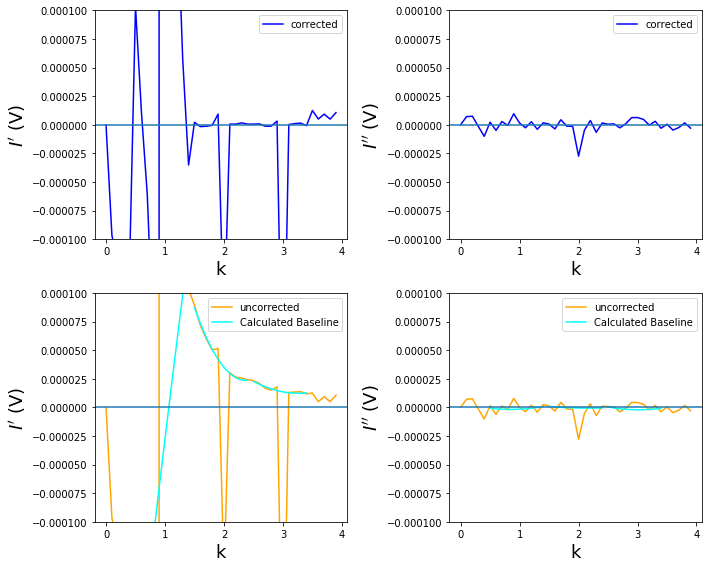

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (10,8))

ax[0,0].plot(k_idx, np.real(i_idx), label = 'corrected', color = 'b')
ax[0,1].plot(k_idx, np.imag(i_idx), label = 'corrected', color = 'b')

ax[1,0].plot(k_idx, np.real(d['uncorrected_i']), label = 'uncorrected', color = 'orange')
ax[1,0].plot(d[1]['k'], np.real(d[1]['calculated_ibs']), color = 'cyan', label = 'Calculated Baseline')
ax[1,0].plot(d[2]['k'], np.real(d[2]['calculated_ibs']), color = 'cyan')
ax[1,0].plot(d[3]['k'], np.real(d[3]['calculated_ibs']), color = 'cyan')

ax[1,1].plot(k_idx, np.imag(d['uncorrected_i']), label = 'uncorrected', color = 'orange')
ax[1,1].plot(d[1]['k'], np.imag(d[1]['calculated_ibs']), color = 'cyan', label = 'Calculated Baseline')
ax[1,1].plot(d[2]['k'], np.imag(d[2]['calculated_ibs']), color = 'cyan')
ax[1,1].plot(d[3]['k'], np.imag(d[3]['calculated_ibs']), color = 'cyan')

for i in range(0,2):
    ax[i,0].set_ylim(-1e-4, 1e-4)
    ax[i,0].axhline(y=0)
    ax[i,0].legend()
    ax[i,0].set_xlabel('k', fontsize = 18)
    ax[i,0].set_ylabel(r'$I^{\prime}$ (V)', fontsize = 18, family = 'sans-serif')
    
    ax[i,1].set_ylim(-1e-4, 1e-4)
    ax[i,1].axhline(y=0)
    ax[i,1].legend()
    ax[i,1].set_xlabel('k', fontsize = 18)
    ax[i,1].set_ylabel(r'$I^{\prime\prime}$ (V)', fontsize = 18, family = 'sans-serif')


plt.tight_layout()
print("Frequency =", frequency, 'Hz')
print("Amplitude =", amplitude, 'A')
plt.show()

### Pure Resistor Data: Instrument Offset

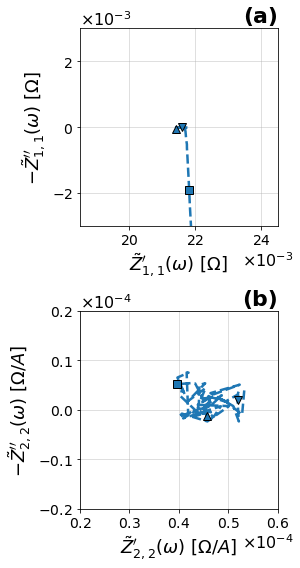

With baseline corrections implemented,
The ohmic resistance of of the resistor is 0.021677767327288173 Ohms
The real and imaginary offset in the 2nd harmonic is 4.555423556387487e-05 , -1.749125505428773e-06 Ohms/A , respectively


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from utilities.plotting import plot_nyquist

directories = ['../data/raw/resistor/']
SoCs = ['0']

frequencies, Z1s, Z2s = get_impedances(directories=directories, SoCs=SoCs, 
                                       correction=np.complex(0, 0))

#frequencies = np.loadtxt('../data/impedance_results/resistor/freq_bcorrected.txt')
#Z1s = np.loadtxt('../data/impedance_results/resistor/Z1s_bcorrected.txt').view(complex)
#Z2s = np.loadtxt('../data/impedance_results/resistor/Z2s_bcorrected.txt').view(complex)

names = ['resistor']

mask = np.array(frequencies) <= 1000

fig1 = plt.figure(1, figsize=(4,8))
ax1 = fig1.add_subplot(211)

ax1 = plot_nyquist(fig1, ax1, frequencies, Z1s, 1, '', [[.0185,.0245],[-.003,.003], -3], names=names, markers=[1000, 1, .01])
ax1.set_title('(a)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')

ax2 = fig1.add_subplot(212)
ax2 = plot_nyquist(fig1, ax2, frequencies, Z2s, 2, '', [[2e-5, 6e-5],[-2e-5, 2e-5], -4], mask=mask, markers=[1000, 1, .01])
ax2.set_title('(b)', weight='bold', family='sans-serif', fontsize=22, loc='right', verticalalignment='baseline')

ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print("With baseline corrections implemented,")
print("The ohmic resistance of of the resistor is", np.real([Z1s[:36]]).mean(),
     "Ohms")
print("The real and imaginary offset in the 2nd harmonic is",
      np.real([Z2s[0][mask]]).mean(), ",",
      np.imag([Z2s[0][mask]]).mean(), "Ohms/A , respectively")

#fig1.savefig('../figures/baseline_correction_figures/Resistor.png', dpi=300, bbox_inches='tight')